In [3]:
import datetime
import geopandas as gpd
import glob
import h3
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import shapely
from shapely import Polygon
from shapely import wkt
from shapely.plotting import plot_polygon

from matplotlib.ticker import FuncFormatter


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

#Set color palette in code
colors = ['#8468F5','#EC74E7','#B2B2B2','#FFCB5C','#46B6E8','#2FD4A1','#333333']
sns.set_palette(sns.color_palette(colors), n_colors = 7)

# 1 Pre-processing

## 1.1 Download a map of Finland using GADM
Use GADM to download the multipolygon of the Helsinki area. We will use the multipolygon in the background of the plots.

## 1.2 Read pre-processed data
Read the pre-processed station and journey data.

# 2 Data analysis

The purpose of the data analysis is to get insights of the data. First we will only focus on features that can be found straightaway from the data. Then we start using hexagons to see regional differences. And then we demonstrate how we can pick one hexagon and get insights from one selected region.

## 2.1 Analyse the data
We focus on answering the following questions:
- In which year were the stations added?
- How has the number of trips changed over the years?
- What is the typical duration and length of a bike journey?
- Which times are the busiest for the bikes?


## 2.2 Analyse the data on hexagon level
We use hexagons to answer the following questions:
- What is a good hexagon resolution to analyze the Helsinki city bike data?
- Where do we have the most stations?
- In which parts of the Helsinki area are there the highest number of departures?
- How long is a typical trip in different parts of Helsinki?


## 2.3 Analyse the data on one selected hexagon
We select one hexagon in central Helsinki and analyze that data further:
- When are city bikes typically used (weekday and hour)?

## 2.4 Select one station and analyse data nearby that station:
We select one location and find hexagons around it.


# 3 Basic H3 functions

## 3.1 Hexagon index
With given coordinates (latitude and longitude) and with selected resolution, we get the hexagon id:
```
# Version 3.X:
hexagon_index = h3.geo_to_h3(lat, lng, resolution)

# Version 4.X:
hexagon_index = h3.latlng_to_cell(lat, lng, resolution)
```
## 3.2 Hexagon boundaries
For plotting certain hexagons, we need to find the hexagon boundaries using the hexagon index:
**Note**: in some systems coordinates are given as (lng, lat) and in another system (lat, lng). With `geo_json=True/False` these coordinates can be swapped.

```
# Version 3.X:
boundary = h3.h3_to_geo_boundary(hexagon_index, geo_json=False)

# Version 4.X:
boundary = h3.cell_to_boundary(hexagon_index, geo_json=False)
```
Then using the library `shapely` we can plot the hexagon:
```
polygon = Polygon(boundary)
plot_polygon(polygon)
```


## 3.3 Neighbouring hexagons
Sometimes we need to find the neighbours of certain hexagon. K=0 returns the origin index, k=1 returns the origin index and all neighboring indices, and so on.

```
# Version 3.X:
kring = h3.k_ring(hexagon_index, k)

# Version 4.X:
kring = h3.grid_disk(hexagon_index, k)
```

Also we can calculate the grid distance between two cells:

```
# Version 3.X:
kring = h3.h3_distance(hexagon_index_a, hexagon_index_a)

# Version 4.X:
kring = h3.grid_distance(hexagon_index_a, hexagon_index_a)
```

# 1.1 Download a map of Finland using GADM (for plotting background)

For plotting purposes, we download the multipolygon of Helsinki area.

In [4]:
import geopandas as gpd
from gadm import GADMDownloader
import numpy as np
import shapely
from shapely.ops import transform

def flip(x,y):
    return y,x

downloader = GADMDownloader(version="4.0")

country_name = "Finland"
ad_level = 2
gdf = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)

# If latitude and longitude are flipped, perform this line:
#gdf.loc[0, 'geometry'] = transform(flip,gdf['geometry'].iloc[0])

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

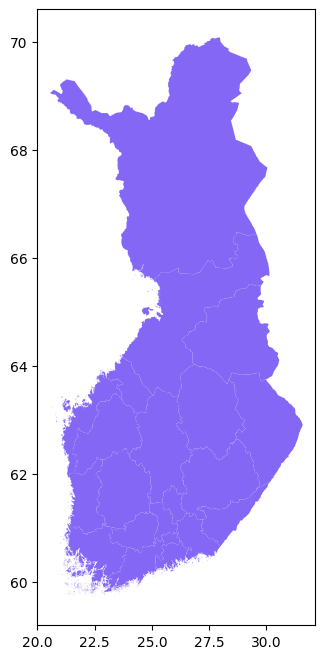

In [5]:
# Let's plot the multipolygon of Finland:
gdf.plot(figsize=(12,8))

In [6]:
# Here we only need one area in Finland called Uusimaa, so let's take only that into account.
gdf = gdf[(gdf.NAME_2 == 'Uusimaa')|(gdf.NAME_2 == 'Eastern Uusimaa')].reset_index()

# 1.2 Read pre-processed station and journey data
In the notebook `City-bikes-data-cleaning.ipynb` we clean and pre-processes the data and save it locally as csv file.

## Reading the station data

In [7]:
file_path = './bike_data/city-bike-stations-cleaned.csv'
df_stations = pd.read_csv(file_path)

df_stations.head()

,ID,Name,Address,City,Capacity,lng,lat,h3_res6,h3_res7,h3_res8,h3_res9,Year,Year_last_used
0,501,Hanasaari,Hanasaarenranta 1,Espoo,10,24.840319,60.165820,86089969fffffff,87089969affffff,88089969a3fffff,89089969a33ffff,2018,2021
1,503,Keilalahti,Keilalahdentie 2,Espoo,28,24.827467,60.171524,86089969fffffff,870899698ffffff,8808996985fffff,8908996984fffff,2018,2021
2,505,Westendinasema,Westendintie 1,Espoo,16,24.805758,60.168266,86089969fffffff,87089969effffff,880899698dfffff,890899698dbffff,2018,2021
3,507,Golfpolku,Golfpolku 3,Espoo,16,24.796136,60.168143,86089969fffffff,87089969effffff,88089969ebfffff,89089969eb7ffff,2018,2021
4,509,Revontulentie,Revontulentie 10,Espoo,30,24.802938,60.171551,86089969fffffff,870899698ffffff,880899698dfffff,890899698d3ffff,2018,2021


In [8]:
print("Number of stations: ", df_stations.ID.nunique())

Number of stations:  457


### Pick some station names that can be used in plots

In [9]:
# Selected stations:
plot_names= ['Keilaniemi (M)', 'Leppävaaranaukio', 'Hakaniemi (M)', 'Kaivopuisto', 'Matinkyläntie', 'Pihlajamäki',
             'Itäkeskus (M)', 'Mellunmäki (M)', 'Puistolan asema', 'Malmin asema', 'Herttoniemi (M)',
             'Laajasalon ostoskeskus', 'Pasilan asema', 'Pohjois-Haagan asema', 'Malminkartanon asema']

plot_names = df_stations[df_stations.Name.isin(plot_names)]

In [10]:
# Coordinates of central Helsinki
plot_helsinki = pd.DataFrame([['Helsinki', 60.169832654, 24.938162914]], columns=['Name', 'lat', 'lng'])

## Reading the journey data

In [11]:
directory_path = './bike_data/city-bike-trips-cleaned.csv'
df_trips = pd.read_csv(directory_path)

# Change the timestamps into datetime
df_trips['Departure'] = pd.to_datetime(df_trips['Departure'])
df_trips['Return'] = pd.to_datetime(df_trips['Return'])

df_trips['departure_date'] = pd.to_datetime(df_trips['departure_date'])
df_trips['return_date'] = pd.to_datetime(df_trips['return_date'])

df_trips.head()

/var/folders/rh/tdl1848n3d19t299sb2gfsl40000gn/T/ipykernel_30176/3154344624.py:2: DtypeWarning: Columns (25,26,27,28,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trips = pd.read_csv(directory_path)


,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.),departure_day_name,departure_weekday,departure_hour,departure_day,departure_month,departure_date,departure_year,return_day_name,return_weekday,return_hour,return_day,return_month,return_date,return_year,departure_ID,departure_lng,departure_lat,departure_h3_res6,departure_h3_res7,departure_h3_res8,departure_h3_res9,return_ID,return_lng,return_lat,return_h3_res6,return_h3_res7,return_h3_res8,return_h3_res9
0,2018-06-30 23:59:56,2018-07-01 00:12:00,44,Sörnäisten metroasema,70,Sammonpuistikko,3199.0,756.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,44.0,24.960554,60.187713,861126d07ffffff,871126d06ffffff,881126d061fffff,891126d0603ffff,70.0,24.922411,60.173147,861126d37ffffff,871126d30ffffff,881126d303fffff,891126d3027ffff
1,2018-06-30 23:59:33,2018-07-01 00:06:00,22,Rautatientori / länsi,22,Rautatientori / länsi,104.0,391.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,22.0,24.939760,60.170606,861126d37ffffff,871126d33ffffff,881126d331fffff,891126d338fffff,22.0,24.939760,60.170606,861126d37ffffff,871126d33ffffff,881126d331fffff,891126d338fffff
2,2018-06-30 23:59:27,2018-07-01 00:06:00,27,Eerikinkatu,63,Jätkäsaarenlaituri,1247.0,422.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,27.0,24.936642,60.167706,861126d37ffffff,871126d33ffffff,881126d339fffff,891126d338bffff,63.0,24.921490,60.161931,861126d37ffffff,871126d30ffffff,881126d307fffff,891126d307bffff
3,2018-06-30 23:59:23,2018-07-01 00:03:00,127,Teurastamo,125,Arielinkatu,791.0,227.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,127.0,24.971157,60.189695,861126d07ffffff,871126d06ffffff,881126d063fffff,891126d063bffff,125.0,24.979739,60.185922,861126d07ffffff,871126d02ffffff,881126d067fffff,891126d066fffff
4,2018-06-30 23:59:23,2018-07-01 00:07:00,27,Eerikinkatu,63,Jätkäsaarenlaituri,1251.0,485.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,27.0,24.936642,60.167706,861126d37ffffff,871126d33ffffff,881126d339fffff,891126d338bffff,63.0,24.921490,60.161931,861126d37ffffff,871126d30ffffff,881126d307fffff,891126d307bffff


# 2.1 Analyse the data

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/var/folders/rh/tdl1848n3d19t299sb2gfsl40000gn/T/ipykernel_30176/841972707.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=use_data, x='departure_year', y='Return station name', ax=ax['B'],
/var/folders/rh/tdl1848n3d19t299sb2gfsl40000gn/T/ipykernel_30176/841972707.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=use_data, x='departure_year', y='Return', ax=ax['C'], co

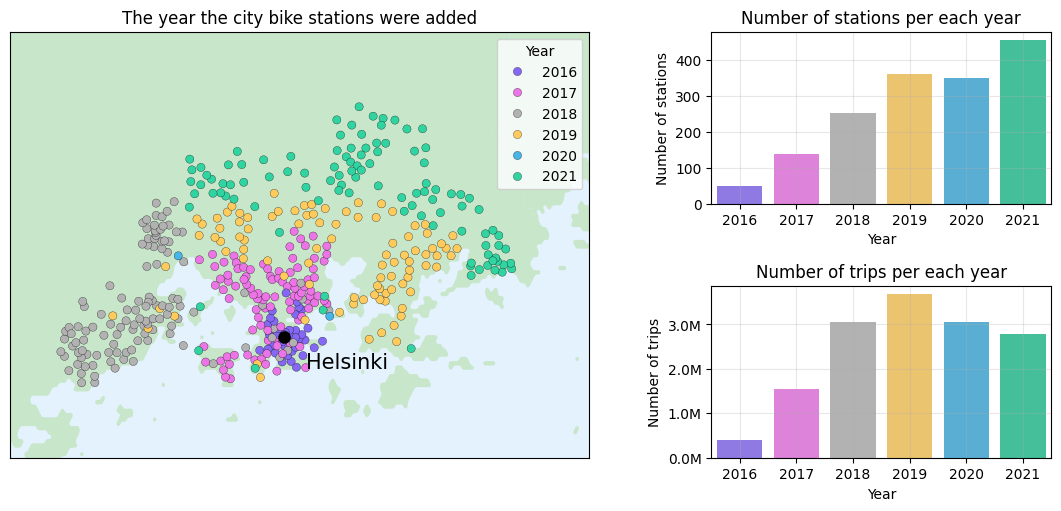

In [12]:
# For plotting, we might need millions formatter:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

fig,ax = plt.subplot_mosaic("AAB;AAC",figsize=(11,5),constrained_layout=True)

xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

# First plot: map with bike stations
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

sns.scatterplot(data=df_stations, x='lng', y='lat', hue='Year', ax= ax['A'], marker='o', s=35, linewidth=0.2,
                palette=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]], edgecolor='black')
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'The year the city bike stations were added')

# Plot the center of Helsinki
ax['A'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=65)
ax['A'].annotate(plot_helsinki.loc[0, 'Name'], 
                (0.021+plot_helsinki.loc[0, 'lng'], -0.015+plot_helsinki.loc[0, 'lat']), fontsize=15)
    
ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)

# Second plot: number of stations per each year
use_data = df_trips.groupby(['departure_year'])[['Return station name']].nunique().reset_index()
sns.barplot(data=use_data, x='departure_year', y='Return station name', ax=ax['B'],
            palette=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]])
ax['B'].set(title = 'Number of stations per each year', xlabel='Year', ylabel='Number of stations')
ax['B'].grid(alpha=0.3)

# Third plot: number of trips per each year
use_data = df_trips.groupby(['departure_year'])[['Return']].count().reset_index()
sns.barplot(data=use_data, x='departure_year', y='Return', ax=ax['C'], color='black',
            palette=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]])
ax['C'].set(title = 'Number of trips per each year', xlabel='Year', ylabel='Number of trips')
ax['C'].grid(alpha=0.3)

formatter = FuncFormatter(millions)
ax['C'].yaxis.set_major_formatter(formatter)



[Text(0, 0.5, 'Number of departures'),
 Text(0.5, 1.0, 'Daily amount of departures')]

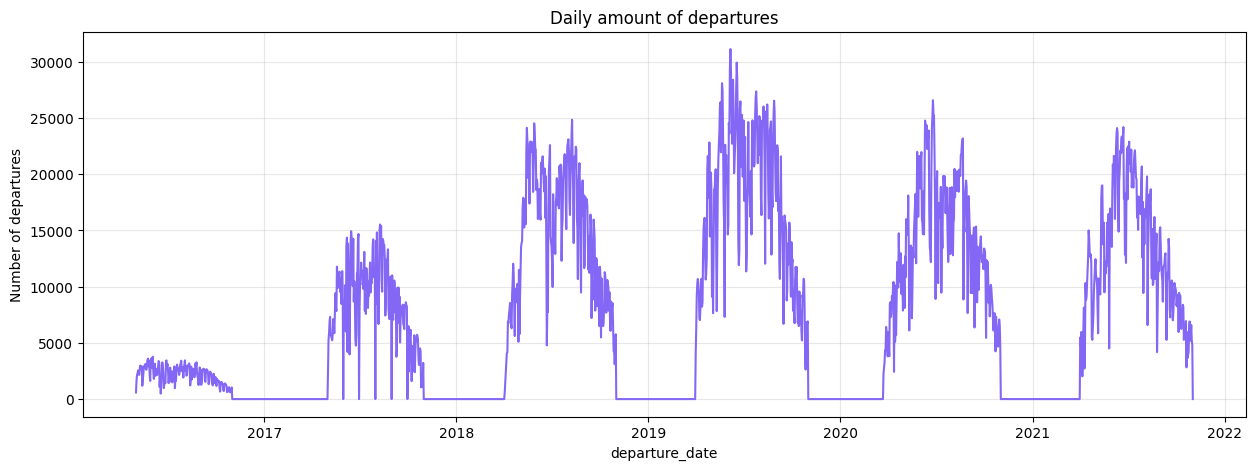

In [13]:
use_data = df_trips.groupby(['departure_date']).Departure.count().reset_index()

timerange =  pd.date_range(df_trips['departure_date'].min(),
                           df_trips['departure_date'].max()+pd.Timedelta(days=1),
                           freq='1d')
all_slots = pd.DataFrame({'time':timerange})

all_slots['departure_date'] = pd.to_datetime(all_slots['time'].dt.date)
use_data = pd.merge(all_slots, use_data, how="left", on=['departure_date'])
use_data.Departure = use_data.Departure.fillna(0)

use_data = use_data.groupby(['departure_date']).mean().reset_index()


fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data, x='departure_date', y='Departure')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of departures', title = 'Daily amount of departures')

### Add duration and covered distance categories to the trips.

In [14]:
df_trips.loc[(df_trips['Duration (sec.)'] < 10*60), 'duration_cat'] = '0-10 min'
df_trips.loc[(df_trips['Duration (sec.)'] >= 10*60)&(df_trips['Duration (sec.)'] < 20*60), 'duration_cat'] = '10-20 min'
df_trips.loc[(df_trips['Duration (sec.)'] >= 20*60)&(df_trips['Duration (sec.)'] < 30*60), 'duration_cat'] = '20-30 min'
df_trips.loc[(df_trips['Duration (sec.)'] >= 30*60), 'duration_cat'] = '30+ min'

df_trips.loc[(df_trips['Covered distance (m)'] < 1000), 'distance_cat'] = '0-1 km'
df_trips.loc[(df_trips['Covered distance (m)'] >= 1000) & (df_trips['Covered distance (m)'] < 3000), 'distance_cat'] = '1-3 km'
df_trips.loc[(df_trips['Covered distance (m)'] >= 3000) & (df_trips['Covered distance (m)'] < 5000), 'distance_cat'] = '3-5 km'
df_trips.loc[(df_trips['Covered distance (m)'] >= 5000), 'distance_cat'] = '5+ km'



/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


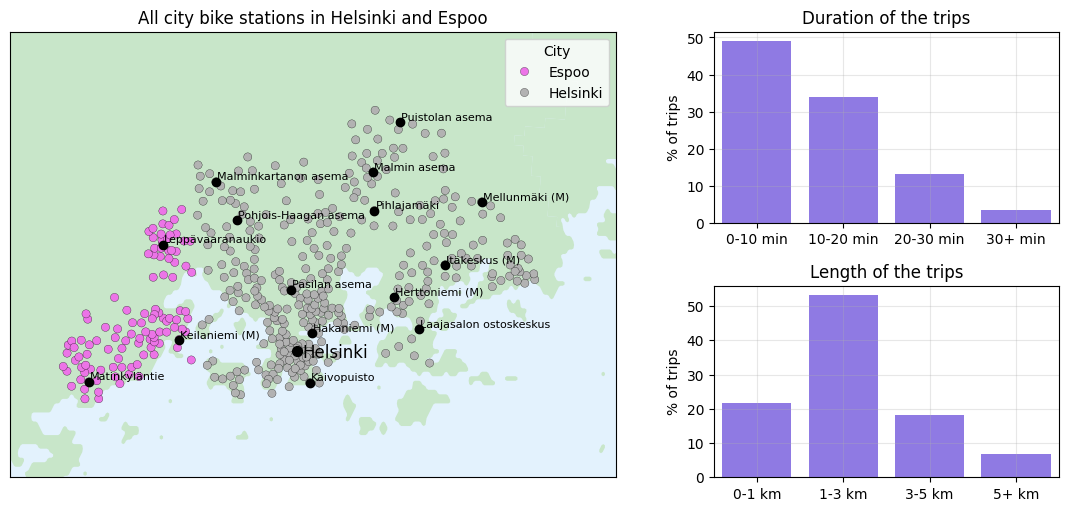

In [15]:
fig,ax = plt.subplot_mosaic("AAB;AAC",figsize=(11,5),constrained_layout=True)

xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

# First plot: map with bike stations
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

sns.scatterplot(data=df_stations, x='lng', y='lat', hue='City', ax= ax['A'], marker='o', s=35, linewidth=0.2,
                palette=[colors[1], colors[2]], edgecolor='black')
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'All city bike stations in Helsinki and Espoo')

# Plot the center of Helsinki
ax['A'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=50)
ax['A'].annotate(plot_helsinki.loc[0, 'Name'], 
            (0.005+plot_helsinki.loc[0, 'lng'], -0.003+plot_helsinki.loc[0, 'lat']), fontsize=12)



ax['A'].scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax['A'].annotate(plot_names.loc[i, 'Name'], 
                     (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)
    
ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# Second plot:
use_data = df_trips.groupby(['duration_cat']).Departure.count().reset_index()
use_data['%'] = 100*use_data['Departure'] / use_data.Departure.sum()

sns.barplot(data=use_data, x='duration_cat', y='%', ax=ax['B'], color=colors[0])
ax['B'].grid(alpha=0.3)
ax['B'].set(title='Duration of the trips', ylabel='% of trips', xlabel=None)


# Third plot:
use_data = df_trips.groupby(['distance_cat']).Departure.count().reset_index()
use_data['%'] = 100*use_data['Departure'] / use_data.Departure.sum()

sns.barplot(data=use_data, x='distance_cat', y='%', ax=ax['C'], color=colors[0])
ax['C'].set(title='Length of the trips', ylabel='% of trips', xlabel=None)
ax['C'].grid(alpha=0.3)

### Remove years 2016 and 2017 as there were so little data.

In [16]:
len_before = len(df_trips)

# Years 2016 and 2017 have limited amount of data and there's multiple issues with the stations ids from year 2016.
# Let's drop them from further analysis so that they don't have too big impact to the statistics.
df_trips = df_trips[pd.to_datetime(df_trips['Departure']).dt.year > 2017]

print("Numbers of rows removed: ", len_before - len(df_trips))

Numbers of rows removed:  1944069


### Continue with the analysis.

[Text(0, 0.5, 'Number of departures'),
 Text(0.5, 1.0, 'Average number of hourly departures'),
 Text(0.5, 0, '')]

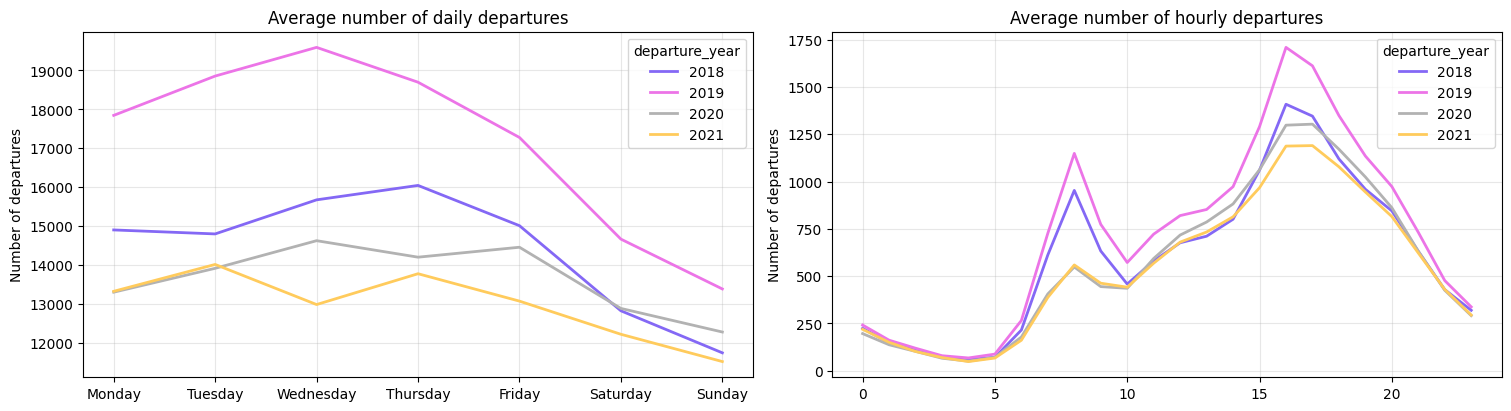

In [17]:
fig,ax = plt.subplot_mosaic("AB",figsize=(15,4),constrained_layout=True)


# First plot:
use_data = df_trips.groupby(['departure_day_name', 'departure_weekday', 'departure_year', 'departure_date'])\
                   .Departure.count().reset_index()
use_data = use_data.groupby(['departure_day_name', 'departure_weekday', 'departure_year'])\
                   .Departure.mean().reset_index()

sns.lineplot(data=use_data.sort_values(by='departure_weekday'), x='departure_day_name', y='Departure', ax=ax['A'],
                  hue='departure_year', palette=[colors[0],colors[1],colors[2],colors[3]], linewidth=2)
ax['A'].grid(alpha=0.3)
ax['A'].set(ylabel='Number of departures', title = 'Average number of daily departures',
            xlabel=None)


# Second plot:
use_data = df_trips.groupby(['departure_hour', 'departure_year', 'departure_date'])\
                   .Departure.count().reset_index()
use_data = use_data.groupby(['departure_hour', 'departure_year'])\
                   .Departure.mean().reset_index()

sns.lineplot(data=use_data, x='departure_hour', y='Departure', ax=ax['B'],
                  hue='departure_year', palette=[colors[0],colors[1],colors[2],colors[3]], linewidth=2)
ax['B'].grid(alpha=0.3)
ax['B'].set(ylabel='Number of departures', title = 'Average number of hourly departures',
            xlabel=None)

# 2.2 Analyse the data on hexagon level
We mostly use resolutions 6, 7 and 8.

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


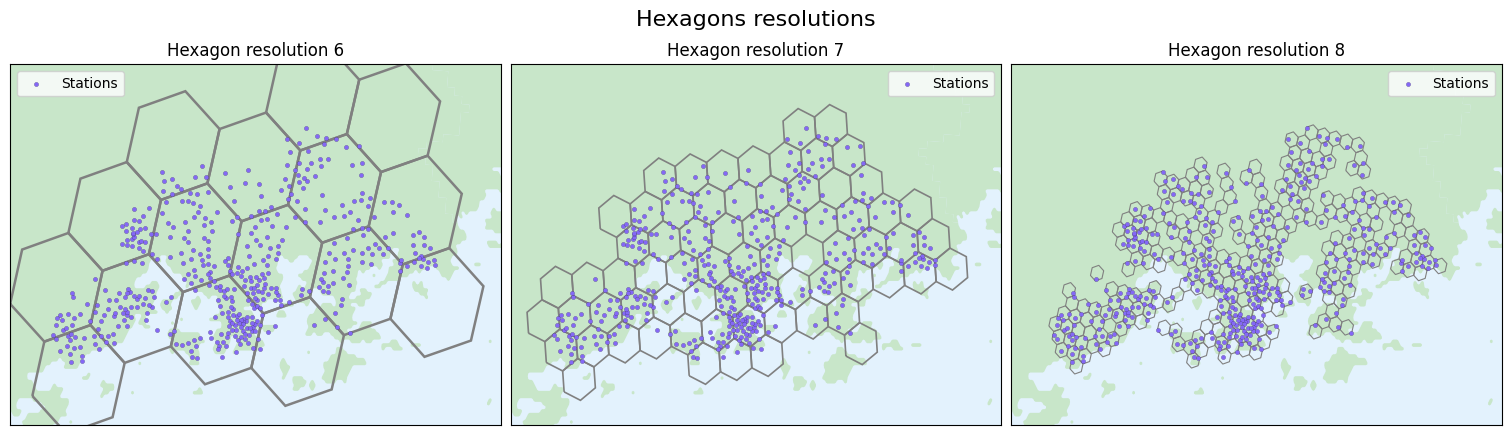

In [51]:
fig,ax = plt.subplot_mosaic("ABC", figsize = (15,5), constrained_layout=True)


xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

fig.suptitle('Hexagons resolutions', size=16, y=0.97)

# ------------------------------
# First plot:
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

col = 'h3_res6'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], facecolor='None', edgecolor='gray', linewidth=1.8)

sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['A'], label='Stations',
                edgecolor='black', linewidth=0.1)
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Hexagon resolution 6')
    
ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# ------------------------------
# Second plot:
gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)
ax['B'].set_facecolor('#E3F2FD')

col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], facecolor='None', edgecolor='gray', linewidth=1.2)
    
sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['B'], label='Stations',
                edgecolor='black', linewidth=0.1)

ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Hexagon resolution 7')
    
ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)


# ------------------------------
# Third plot:
gdf.plot(ax=ax['C'], color='#C8E6C9', alpha=1)
ax['C'].set_facecolor('#E3F2FD')

col = 'h3_res8'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['C'], facecolor='None', edgecolor='gray', linewidth=0.8)
sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['C'], label='Stations',
                edgecolor='black', linewidth=0.1)

ax['C'].set_xlim(xlims)
ax['C'].set_ylim(ylims)
ax['C'].set(title = 'Hexagon resolution 8')
    
ax['C'].get_xaxis().set_visible(False)
ax['C'].get_yaxis().set_visible(False)



/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


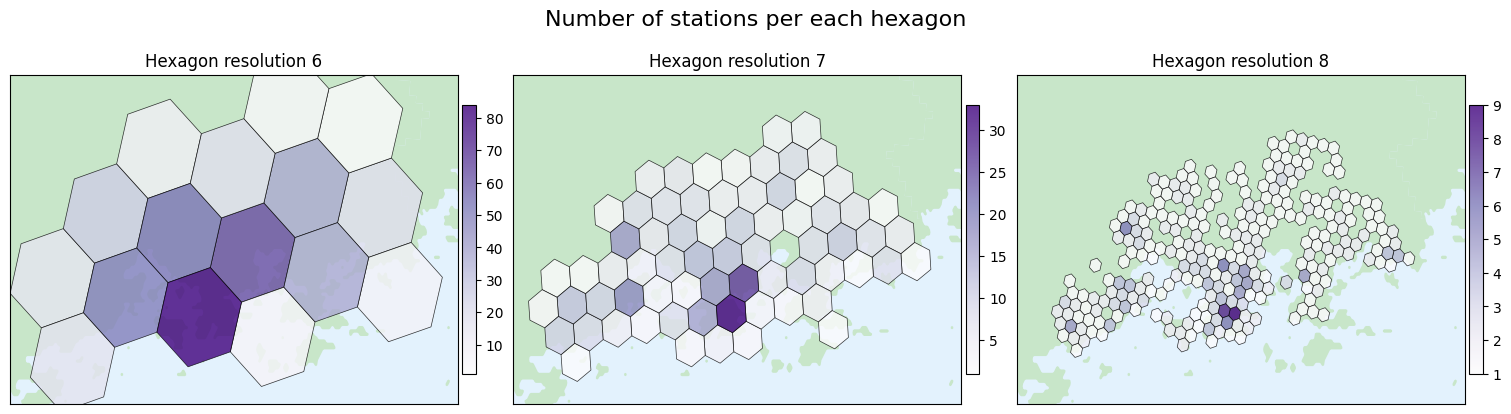

In [53]:
fig,ax = plt.subplot_mosaic("ABC",figsize = (15,5), constrained_layout=True)

xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

fig.suptitle('Number of stations per each hexagon', size=16, y=0.96)

# ------------------------------
# First plot:
col_hexa = 'h3_res6'
col_by = "Name"
ax['A'].set_facecolor('#E3F2FD')
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Hexagon resolution 6')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['A'], alpha=0.8)

ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# ------------------------------
# Second plot:
col_hexa = 'h3_res7'
col_by = "Name"
ax['B'].set_facecolor('#E3F2FD')
gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Hexagon resolution 7')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['B'], alpha=0.8)

ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)


# ------------------------------
# Third plot:
col_hexa = 'h3_res8'
col_by = "Name"
ax['C'].set_facecolor('#E3F2FD')
gdf.plot(ax=ax['C'], color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['C'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    

ax['C'].set_xlim(xlims)
ax['C'].set_ylim(ylims)
ax['C'].set(title = 'Hexagon resolution 8')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['C'], alpha=0.8)

ax['C'].get_xaxis().set_visible(False)
ax['C'].get_yaxis().set_visible(False)

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


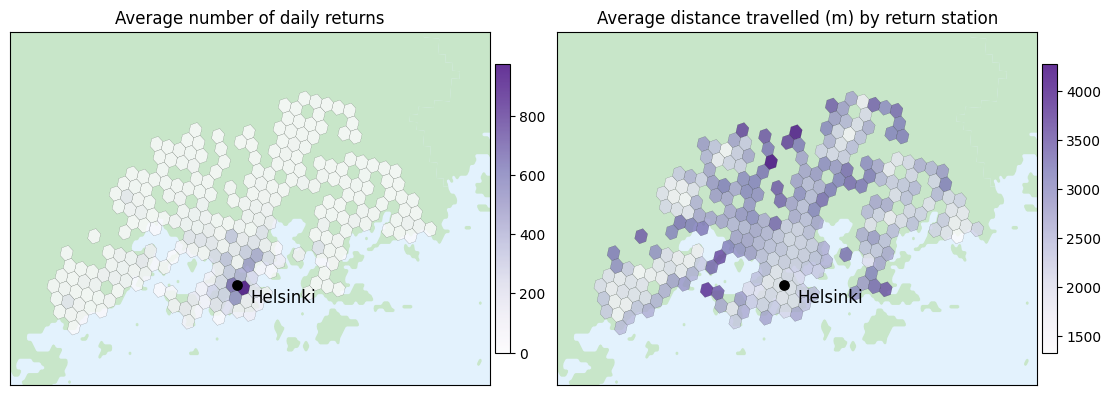

In [20]:
fig,ax = plt.subplot_mosaic("AB",figsize=(11,7),constrained_layout=True)

xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

# First plot:

gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

col_hexa = 'return_h3_res8'
col_by = "Return"
num_trips = df_trips.groupby([col_hexa,'return_date'])[[col_by]].count().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by])/ (num_trips[col_by].max())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.1)
    
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Average number of daily returns')
norm = plt.Normalize(0, num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['A'], alpha=0.8)

# Plot the center of Helsinki
ax['A'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=45)
ax['A'].annotate(plot_helsinki.loc[0, 'Name'], 
                (0.015+plot_helsinki.loc[0, 'lng'], -0.01+plot_helsinki.loc[0, 'lat']), fontsize=12)


ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# Second plot:

gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)
ax['B'].set_facecolor('#E3F2FD')

col_hexa = 'return_h3_res8'
col_by = 'Covered distance (m)'
num_trips = df_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.1)
    
ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Average distance travelled (m) by return station')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['B'], alpha=0.8)

# Plot the center of Helsinki
ax['B'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=45)
ax['B'].annotate(plot_helsinki.loc[0, 'Name'], 
                (0.015+plot_helsinki.loc[0, 'lng'], -0.01+plot_helsinki.loc[0, 'lat']), fontsize=12)

ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)


/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


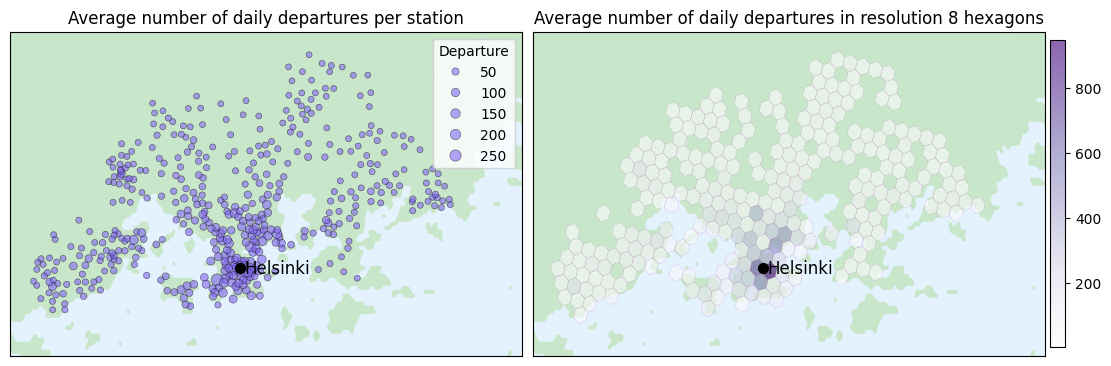

In [54]:
fig,ax = plt.subplot_mosaic("AB",figsize=(11,7),constrained_layout=True)

xlims = [0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()]


# -----------------------
# First plot:


gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

col_by = 'Departure'
use_data = df_trips.groupby(['Departure station id','departure_date'])[[col_by]].count().reset_index()
use_data = use_data.groupby(['Departure station id'])[[col_by]].mean().reset_index()
use_data = pd.merge(df_stations, use_data, how="right", left_on='ID', right_on='Departure station id')

sns.scatterplot(data=use_data, x='lng', y='lat', marker='o', size=col_by, color=colors[0], ax=ax['A'],
                edgecolor='black', linewidth=0.4, alpha=0.6)

ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Average number of daily departures per station')
    
# Plot the center of Helsinki
ax['A'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=50)
ax['A'].annotate(plot_helsinki.loc[0, 'Name'], 
                 (0.005+plot_helsinki.loc[0, 'lng'], -0.003+plot_helsinki.loc[0, 'lat']), fontsize=12)


ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)

# -----------------------
# Second plot:

gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)
ax['B'].set_facecolor('#E3F2FD')

col_hexa = 'departure_h3_res8'
col_by = 'Departure'

num_trips = df_trips.groupby([col_hexa,'departure_date'])[[col_by]].count().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.6, color=cm.Purples(color),
                 edgecolor='purple', linewidth=0.1)
    

ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Average number of daily departures in resolution 8 hexagons')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['B'], alpha=0.6)

    
# Plot the center of Helsinki
ax['B'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=50)
ax['B'].annotate(plot_helsinki.loc[0, 'Name'], 
                (0.005+plot_helsinki.loc[0, 'lng'], -0.003+plot_helsinki.loc[0, 'lat']), fontsize=12)

ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)

# 2.3 Analyse the data on one selected hexagon
We select one hexagon around the central Helsinki and analyse bike trips in that hexagon.

In [22]:
# Select a hexagon around Helsinki main railway station
selected_hexagon = '871126d33ffffff'

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


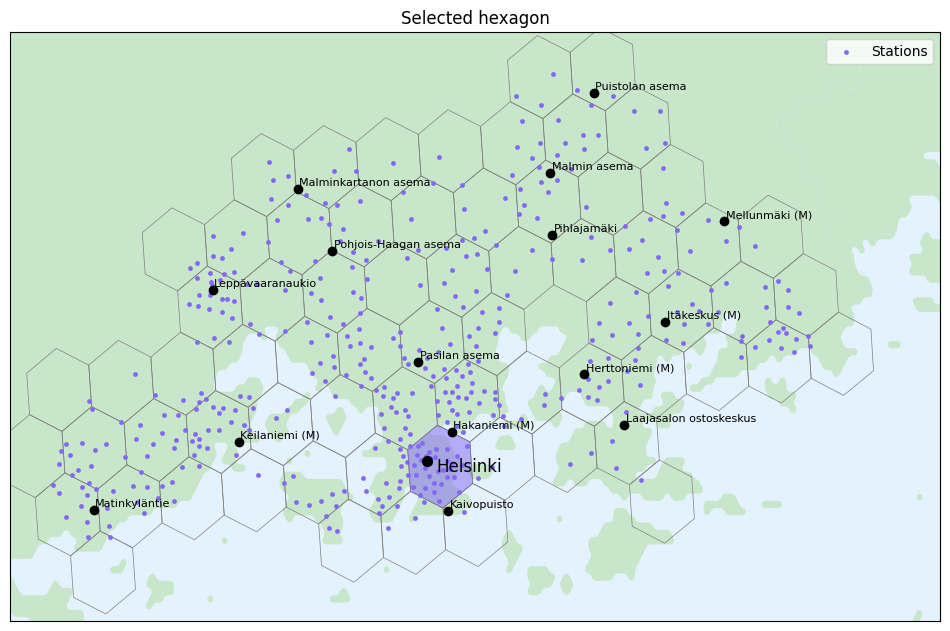

In [23]:
fig, ax = plt.subplots(figsize = (12,10))

xlims = [0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()]

col_hexa = 'h3_res7'
col_by = "Name"
ax.set_facecolor('#E3F2FD')
gdf.plot(ax=ax, color='#C8E6C9', alpha=1)


col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, facecolor='None', edgecolor='gray', linewidth=0.5)

sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax, label='Stations',
                edgecolor=colors[0], linewidth=0.3)

pol = Polygon(h3.h3_to_geo_boundary(selected_hexagon, geo_json=True))
plot_polygon(pol, add_points=False, ax=ax, alpha=0.5, color=colors[0],
             edgecolor='purple', linewidth=0.1)

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set(title = 'Selected hexagon')
    
# Plot the center of Helsinki
ax.scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=50)
ax.annotate(plot_helsinki.loc[0, 'Name'], 
            (0.005+plot_helsinki.loc[0, 'lng'], -0.003+plot_helsinki.loc[0, 'lat']), fontsize=12)


ax.scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax.annotate(plot_names.loc[i, 'Name'], 
                (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

[Text(0, 0.5, 'Number of returns'),
 Text(0.5, 1.0, 'Returns of citybikes in a selected hexagon')]

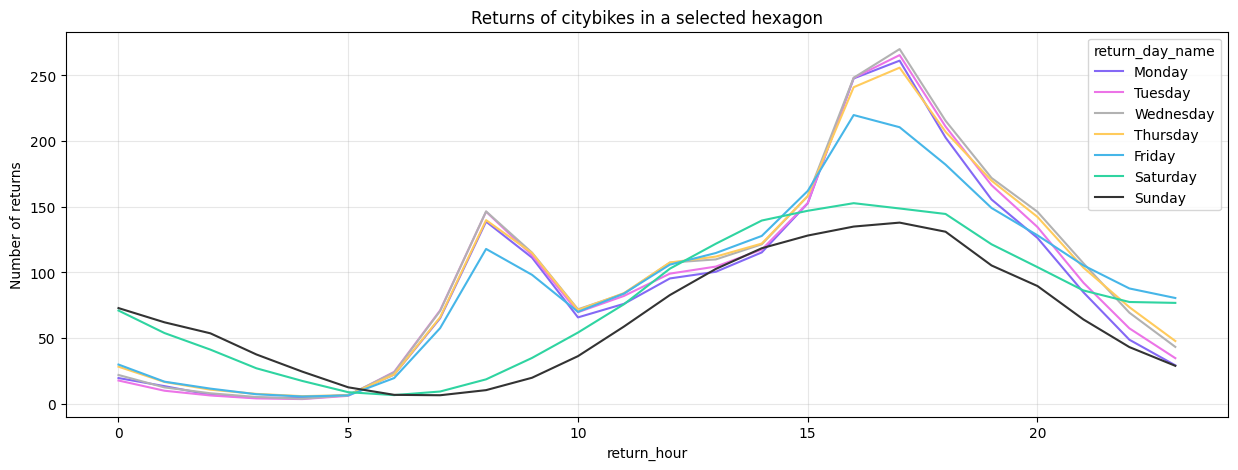

In [24]:
hexa_trips = df_trips[ df_trips['departure_h3_res7'] == selected_hexagon ]

use_data = hexa_trips.groupby(['return_day_name', 'return_weekday','return_hour','return_date']).Return\
                     .count().reset_index()

timerange =  pd.date_range(use_data['return_date'].min(), use_data['return_date'].max()+pd.Timedelta(days=1),
                           freq='1h')
all_slots = pd.DataFrame({'time':timerange})
all_slots['return_hour'] = all_slots['time'].dt.hour
all_slots['return_date'] = pd.to_datetime(all_slots['time'].dt.date)
all_slots['return_weekday'] = all_slots['time'].dt.dayofweek
all_slots['return_day_name'] = all_slots['time'].dt.day_name()
use_data = pd.merge(all_slots, use_data, how="left",
                    on=['return_date', 'return_hour', 'return_weekday', 'return_day_name'])
use_data.Return = use_data.Return.fillna(0)

use_data = use_data.groupby(['return_hour','return_weekday','return_day_name']).mean().reset_index()

fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data.sort_values(by='return_weekday'), x='return_hour', y='Return',
                  hue='return_day_name')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of returns', title = 'Returns of citybikes in a selected hexagon')

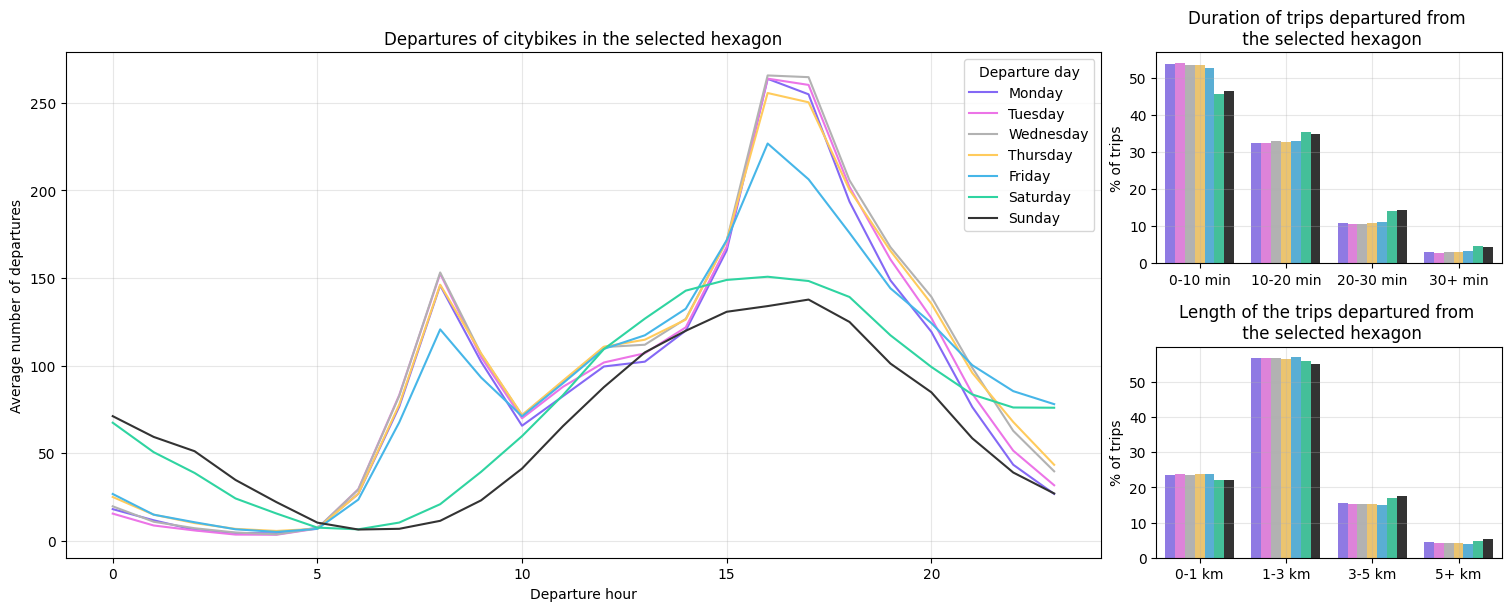

In [25]:
fig,ax = plt.subplot_mosaic("AAAB;AAAC",figsize=(15,6),constrained_layout=True)

xlims = [0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()]


# First plot:

hexa_trips = df_trips[ df_trips['departure_h3_res7'] == selected_hexagon ]
use_data = hexa_trips.groupby(['departure_day_name', 'departure_weekday','departure_hour','departure_date'])\
                     .Departure.count().reset_index()

# There might not be departures on every hour so those timeslots must be considered as zero when taking the average:
timerange =  pd.date_range(use_data['departure_date'].min(), use_data['departure_date'].max()+pd.Timedelta(days=1),
                           freq='1h')
all_slots = pd.DataFrame({'time':timerange})
all_slots['departure_hour'] = all_slots['time'].dt.hour
all_slots['departure_date'] = pd.to_datetime(all_slots['time'].dt.date)
all_slots['departure_weekday'] = all_slots['time'].dt.dayofweek
all_slots['departure_day_name'] = all_slots['time'].dt.day_name()
use_data = pd.merge(all_slots, use_data, how="left",
                    on=['departure_date', 'departure_hour', 'departure_weekday', 'departure_day_name'])
use_data.Departure = use_data.Departure.fillna(0)

use_data = use_data.groupby(['departure_hour','departure_weekday','departure_day_name']).mean().reset_index()

sns.lineplot(data=use_data.sort_values(by='departure_weekday'), x='departure_hour', y='Departure',
                  hue='departure_day_name', ax=ax['A'])
ax['A'].grid(alpha=0.3)
ax['A'].set(xlabel= 'Departure hour', ylabel='Average number of departures', title = 'Departures of citybikes in the selected hexagon')
ax['A'].legend(title='Departure day')


# Second plot:

use_data = hexa_trips.groupby(['duration_cat','departure_day_name', 'departure_weekday']).Departure.count().reset_index()
use_sum = use_data.groupby(['departure_weekday']).Departure.sum().reset_index().rename(columns={'Departure':'Departure_sum'})
use_data = pd.merge(use_data, use_sum, how='left', on='departure_weekday')
use_data['%'] = 100*use_data['Departure'] / use_data['Departure_sum']

sns.barplot(data=use_data.sort_values(by=['duration_cat', 'departure_weekday']), x='duration_cat', y='%', hue='departure_day_name',
            ax=ax['B'])
ax['B'].grid(alpha=0.3)
ax['B'].set(title='Duration of trips departured from \n the selected hexagon', ylabel='% of trips', xlabel=None)
ax['B'].get_legend().remove()

# Third plot:

use_data = hexa_trips.groupby(['distance_cat','departure_day_name', 'departure_weekday']).Departure.count().reset_index()
use_sum = use_data.groupby(['departure_weekday']).Departure.sum().reset_index().rename(columns={'Departure':'Departure_sum'})
use_data = pd.merge(use_data, use_sum, how='left', on='departure_weekday')
use_data['%'] = 100*use_data['Departure'] / use_data['Departure_sum']

sns.barplot(data=use_data.sort_values(by=['distance_cat', 'departure_weekday']), x='distance_cat', y='%', hue='departure_day_name',
            ax=ax['C'])
ax['C'].set(title='Length of the trips departured from \n the selected hexagon', ylabel='% of trips', xlabel=None)
ax['C'].grid(alpha=0.3)
ax['C'].get_legend().remove()

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


[Text(797.5520833333334, 0.5, '% of trips'),
 Text(0.5, 98.25635555555554, 'Distance in grid cells')]

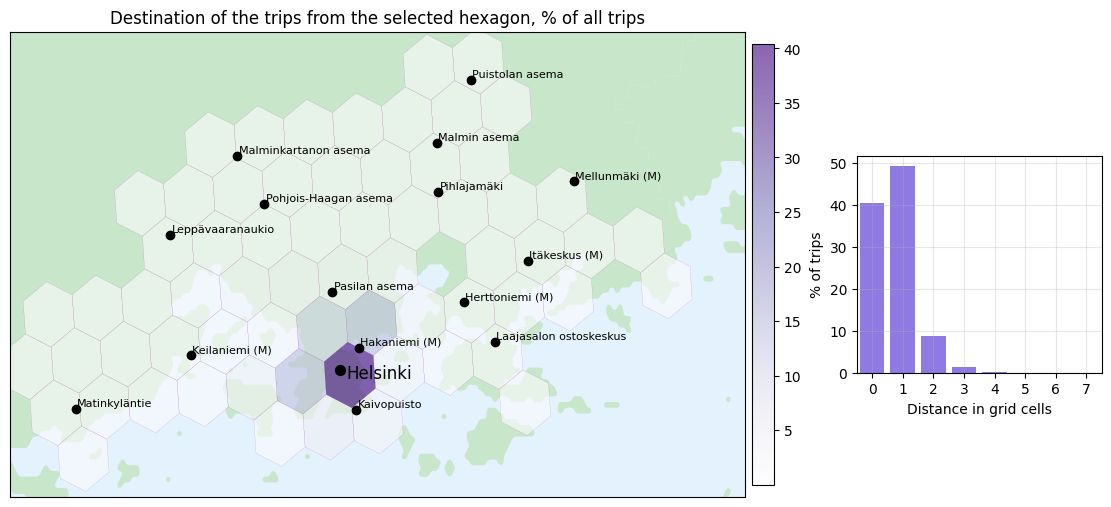

In [27]:
fig,ax = plt.subplot_mosaic("AAA.;AAAB;AAA.",figsize=(11,5),constrained_layout=True, height_ratios=[1, 3, 1])

xlims = [0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()]


# First plot:

col_hexa = 'return_h3_res7'
col_by = 'Return'
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

hexa_trips = df_trips[ df_trips['departure_h3_res7'] == selected_hexagon ]
num_trips = hexa_trips.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips[col_by]= 100*num_trips[col_by]/num_trips[col_by].sum()
num_trips['color_norm'] = num_trips[col_by]/num_trips[col_by].max()


for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], alpha=0.6, color=cm.Purples(color),
                 edgecolor='purple', linewidth=0.1)
    
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Destination of the trips from the selected hexagon, % of all trips')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.03, pad=0.01, ax=ax['A'], alpha=0.6)

ax['A'].scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax['A'].annotate(plot_names.loc[i, 'Name'], 
                    (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)
    
# Plot the center of Helsinki
ax['A'].scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=50)
ax['A'].annotate(plot_helsinki.loc[0, 'Name'], 
            (0.005+plot_helsinki.loc[0, 'lng'], -0.003+plot_helsinki.loc[0, 'lat']), fontsize=12)

ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# Second plot:
for ind in num_trips.index:
    num_trips.loc[ind, 'k_neighbour'] = int(h3.h3_distance(selected_hexagon, num_trips.return_h3_res7.values[ind]))
use_data = num_trips.groupby('k_neighbour').Return.sum().reset_index()
use_data['k_neighbour'] = use_data['k_neighbour'].astype(int)

sns.barplot(data=use_data, x='k_neighbour', y='Return', color=colors[0], ax=ax['B'])
ax['B'].grid(alpha=0.3)
ax['B'].set(ylabel='% of trips', xlabel='Distance in grid cells')


# 2.4 Choose one location and analyse the data around that location
We choose one station in  central Kamppi and focus on data within ~1km from that station.

In [28]:
# Let's choose one station in the central Helsinki:
selected_station = df_stations[df_stations.Name == 'Kamppi (M)'].reset_index()
selected_station

,index,ID,Name,Address,City,Capacity,lng,lat,h3_res6,h3_res7,h3_res8,h3_res9,Year,Year_last_used
0,135,26,Kamppi (M),Fredrikinkatu 44,Helsinki,32,24.930537,60.168609,861126d37ffffff,871126d33ffffff,881126d339fffff,891126d339bffff,2017,2021


/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


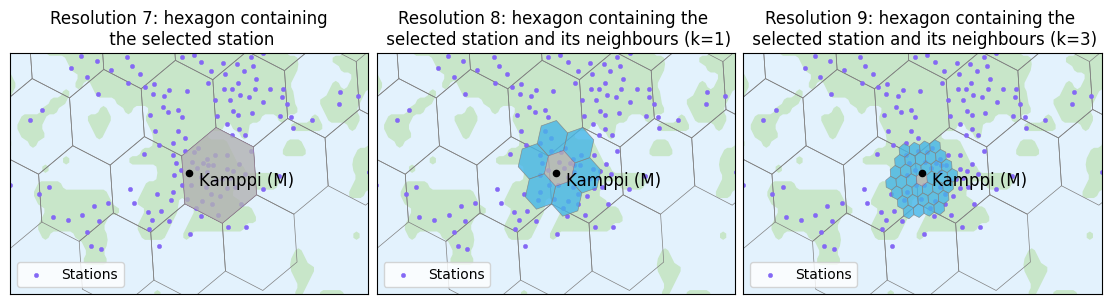

In [57]:
fig,ax = plt.subplot_mosaic("ABC",figsize=(11,7),constrained_layout=True)

lng = selected_station.lng.values[0]
lat = selected_station.lat.values[0]

xlims = [lng-0.09, lng+0.09]
ylims = [lat-0.03, lat+0.03]

# ---------------------------
# First plot:

col_hexa = 'h3_res7'
selected_hexagon = selected_station[col_hexa].values[0]

gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')


col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], facecolor='None', edgecolor='gray', linewidth=0.5)

sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['A'], label='Stations',
                edgecolor=colors[0], linewidth=0.3)

pol = Polygon(h3.h3_to_geo_boundary(selected_hexagon, geo_json=True))
plot_polygon(pol, add_points=False, ax=ax['A'], alpha=0.8, color=colors[2],
             edgecolor='purple', linewidth=0.1)

ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Resolution 7: hexagon containing\n the selected station')
    
# Plot the selected station
ax['A'].scatter(data=selected_station, x='lng', y='lat', color='black', zorder=3, s=20)
ax['A'].annotate(selected_station.loc[0, 'Name'], 
                 (0.005+selected_station.loc[0, 'lng'], -0.003+selected_station.loc[0, 'lat']), fontsize=12)


ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# ---------------------------
# Second plot:

selected_hexagon = selected_station.h3_res8.values[0]

# Find the nearest neighbours: k_ring() will return a set containing also the hexagon itself
# so we need to remove that item and convert set to a list.
kring = h3.k_ring(selected_hexagon, k=1)
kring = list( kring - {selected_hexagon} )

gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)
ax['B'].set_facecolor('#E3F2FD')

col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], facecolor='None', edgecolor='gray', linewidth=0.5)

sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['B'], label='Stations',
                edgecolor=colors[0], linewidth=0.3)


for ind in kring:
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.8, color=colors[4],
                 edgecolor='gray', linewidth=0.5)
    
pol = Polygon(h3.h3_to_geo_boundary(selected_hexagon, geo_json=True))
plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.8, color=colors[2],
             edgecolor='purple', linewidth=0.1)

ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Resolution 8: hexagon containing the \n selected station and its neighbours (k=1)')
    
# Plot the selected station
ax['B'].scatter(data=selected_station, x='lng', y='lat', color='black', zorder=3, s=20)
ax['B'].annotate(selected_station.loc[0, 'Name'], 
                 (0.005+selected_station.loc[0, 'lng'], -0.003+selected_station.loc[0, 'lat']), fontsize=12)


ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)


# ---------------------------
# Third plot:

selected_hexagon = selected_station.h3_res9.values[0]

# Find the nearest neighbours: k_ring() will return a set containing also the hexagon itself
# so we need to remove that item and convert set to a list.
kring = h3.k_ring(selected_hexagon, k=3)
kring = list( kring - {selected_hexagon} )

gdf.plot(ax=ax['C'], color='#C8E6C9', alpha=1)
ax['C'].set_facecolor('#E3F2FD')


col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['C'], facecolor='None', edgecolor='gray', linewidth=0.5)

sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['C'], label='Stations',
                edgecolor=colors[0], linewidth=0.3)


for ind in kring:
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['C'], alpha=0.8, color=colors[4],
                 edgecolor='gray', linewidth=0.5)
    
pol = Polygon(h3.h3_to_geo_boundary(selected_hexagon, geo_json=True))
plot_polygon(pol, add_points=False, ax=ax['C'], alpha=0.8, color=colors[2],
             edgecolor='purple', linewidth=0.1)

ax['C'].set_xlim(xlims)
ax['C'].set_ylim(ylims)
ax['C'].set(title = 'Resolution 9: hexagon containing the \n selected station and its neighbours (k=3)')
    
# Plot the selected station
ax['C'].scatter(data=selected_station, x='lng', y='lat', color='black', zorder=3, s=20)
ax['C'].annotate(selected_station.loc[0, 'Name'], 
                 (0.005+selected_station.loc[0, 'lng'], -0.003+selected_station.loc[0, 'lat']), fontsize=12)


ax['C'].get_xaxis().set_visible(False)
ax['C'].get_yaxis().set_visible(False)


# Appendix

## Background map we are mostly using in our analysis

/Users/saratahtinen/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


[Text(0.5, 61.8218191784413, 'longitude'),
 Text(7.472222222222223, 0.5, 'latitude')]

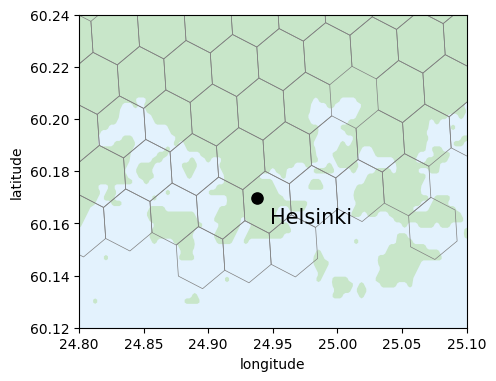

In [93]:
# Background of the map we are mostly using in our analysis:
fig, ax = plt.subplots(figsize = (5,5))

xlims = [24.8, 25.1]
ylims = [60.12, 60.24]
ax.set_xlim(xlims)
ax.set_ylim(ylims)

gdf.plot(ax=ax, color='#C8E6C9', alpha=1)
ax.set_facecolor('#E3F2FD')

ax.scatter(data=plot_helsinki, x='lng', y='lat', color='black', zorder=3, s=65)
ax.annotate(plot_helsinki.loc[0, 'Name'], 
            (0.01+plot_helsinki.loc[0, 'lng'], -0.01+plot_helsinki.loc[0, 'lat']), fontsize=15)

col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, facecolor='None', edgecolor='gray', linewidth=0.5)


ax.set(xlabel = 'longitude', ylabel = 'latitude')

## Filling multipolygon of Finland with hexagons

In [4]:
downloader = GADMDownloader(version="4.0")

country_name = "Finland"
ad_level = 2
gdf = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)

In [7]:
h3_df_area = pd.DataFrame([],columns=['h3_id', 'h3_centroid', 'polygon', 'area']) 

# The smaller the resolution integer, the larger the hexagon area.
resolution = 5

area_column = 'NAME_2'
# Convert multi-polygon into list of polygons
for ind in gdf.index.tolist():
    district_polygon = list(gdf['geometry'].iloc[ind].geoms) 
    area_name = gdf.iloc[ind][area_column]
    for polygon in district_polygon:
        # Convert Polygon to GeoJSON dictionary
        poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
        # Parse out geometry key from GeoJSON dictionary
        poly_geojson = poly_geojson['features'][0]['geometry'] 
        # Fill the dictionary with Resolution X H3 Hexagons
        h3_hexes = h3.polyfill_geojson(poly_geojson, resolution) 
        for h3_hex in h3_hexes:
            polygon = shapely.geometry.Polygon(h3.h3_to_geo_boundary(h3_hex, geo_json=True))
            h3_centroid = h3.h3_to_geo(h3_hex)
            # Append results to dataframe
            h3_df_area.loc[len(h3_df_area)]=[
                h3_hex,
                h3_centroid,
                polygon,
                area_name
            ]

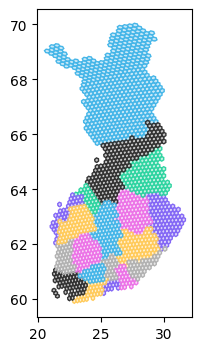

In [9]:
fig, ax = plt.subplots(figsize = (2,4))
areas = h3_df_area.area.unique().tolist()
for ind in h3_df_area.index.tolist():
    pol = h3_df_area.iloc[ind].polygon
    # In the beginning of the notebook, we defined plotting colors as a list (named colors). We have 14 different
    # colors specified in that list. We have more labels than we have colors in the color list so we need to add
    # %len(colors) to reuse some colors (% gives the remainder when dividing a number with another number.)
    area_color = areas.index(h3_df_area.iloc[ind].area) % len(colors)
    plot_polygon(pol, add_points=False, ax=ax, color=colors[area_color])

In [18]:
# Check if there are pentagons in Finland on resolution 5
num_pentagons = 0
for hex_id in h3_df_area.h3_id.tolist():
    if h3.h3_is_pentagon(hex_id):
        num_pentagons += 1
print('Number of pentagons: ', num_pentagons)

Number of pentagons:  0


## Other
The documentation of H3 library is not fully up-to-date, so sometimes I needed to print out all the function names and then use `inspect` to find what arguments the function takes.

In [94]:
import inspect

# Print all h3 functions:
dir(h3)

# Print the arguments of the function:
inspect.signature(h3.polyfill)

<Signature (geojson, res, geo_json_conformant=False)>